![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 13 - Neural Style Transfer (PyTorch).ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 13 - Neural Style Transfer (PyTorch).ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>


# Task 13 - Neural Style Transfer (PyTorch)



In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet. You could use any network, but we chose SqueezeNet here for its small size and efficiency.

Here's an example of the images you'll be able to produce by the end of this notebook:

<center>
  
![caption](https://image.ibb.co/gnqJkA/example-styletransfer.png)


Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = 1301170073
Nama = 'Pratama Yoga Santosa'

## --- end your code here ----

---
---
#[Part 0] Import Libraries and Load Data

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter1d
from PIL import Image
from collections import namedtuple

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)


---
## 1 - Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation.

We provide you with some helper functions to deal with images, since for this part of the assignment we're dealing with real JPEGs, not CIFAR-10 data.

We define a few helper functions for performing and undoing this preprocessing. 

You don't need to do anything in these cells.

---
### a. Preprocess Image

Preprocess an input PIL JPG image to become a Pytorch tensor by normalizing (zero centering) according to `squeezenet` model

you need to change the function if you use another pretrained model

In [3]:
# preprocess image input
def preprocess(img, size=512):

    transform = T.Compose([
        T.Resize(size),                              # Resize the image (preserving aspect ratio) until the shortest side is of length `size`
        T.ToTensor(),                                # Convert the PIL Image to a Pytorch Tensor.
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),   # Normalize the mean of the image pixel values to be SqueezeNet's expected mean, and
                    std=SQUEEZENET_STD.tolist()),    #   the standard deviation to be SqueezeNet's expected std dev.
        T.Lambda(lambda x: x[None]),                 # Add a batch dimension in the first position of the tensor: aka, a tensor of shape (H, W, C) will become -> (1, H, W, C).
    ])
    
    return transform(img)


---
### b. De-Process Image
Denormalize back Pytorch tensor from the output of CNN model into a PIL JPG image for viewing purpose.

It consists of two functions: rescale and the deprocess itself

again, you need to change the function if you use another pretrained model

In [4]:
# Rescale elements of x linearly to be in the interval [0, 1]
def rescale(x):

    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)

    return x_rescaled


# deprocess image result
def deprocess(img):

    transform = T.Compose([
        T.Lambda(lambda x: x[0]),                                                         # Remove the batch dimension at the first position by accessing the slice at index 0.
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),      # Normalize the standard deviation: multiply each channel of the output tensor by 1/s,
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),          # Normalize the mean: subtract the mean (hence the -m) from each channel of the output tensor
        T.Lambda(rescale),                                                                # Rescale all the values in the tensor so that they lie in the interval [0, 1] to prepare for transforming it into image pixel values.
        T.ToPILImage(),                                                                   # Convert the Pytorch Tensor to a PIL Image.
    ])
    
    return transform(img)



---
### c. Relative Error Function

Function to calculate difference between your matrix and our expected results

In [5]:
# calculate relative error between two matrices
def rel_error(x,y):
      return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

---
## 2 - CPU/GPU Setting
This is the optional setting if you're using CPU Processing

In [6]:
dtype = torch.cuda.FloatTensor 

## Uncomment out the following line if you're on a machine with a CPU set up for PyTorch!
# dtype = torch.FloatTensor 

---
## 3 - Load Images
We have provided a few images to try our Style Transfer

There are 1 content image and 4 style images provided
* content image
 * tubingen.jpg
* style images
 * composition_vii.jpg
 * muse.jpg
 * starry_night.jpg
 * the_scream.jpg

you can add more image to your liking


In [7]:
# content image
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/images/tubingen.jpg'

# style images
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/images/composition_vii.jpg'
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/images/muse.jpg'
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/images/starry_night.jpg'
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/images/the_scream.jpg'


---
## 4 - Load File Checker

we also provided a reference matrix to check whether the matrix produced by your implementation matched our expected output

In [8]:
!wget -q 'https://github.com/adf-telkomuniv/CV2020_Exercises/raw/main/resources/style-transfer-checks.npz'

answers = dict(np.load('style-transfer-checks.npz'))

---
## 5 - Library Checking

Older versions of `scipy.misc.imresize` yield different results
from newer versions, so we check to make sure scipy is up to date.

In [9]:
def check_scipy():
  
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

print(check_scipy())

None


**Expected Output**:
<pre>
None

---
---
# [Part 1] SqueezeNet Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

But you can try any other model from PyTorch. See the list [here](https://pytorch.org/docs/stable/torchvision/models.html)

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

---
## 1 - Load SqueezeNet

Download and load the pretrained SqueezeNet model.

In [10]:
# load squeezenet
cnn_model = torchvision.models.squeezenet1_1(pretrained=True).features

# move the model to the device you are using (GPU or CPU)
cnn_model.type(dtype)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 

---
## 2 - Freeze the Model
We don't want to train the model, so tell PyTorch not to compute gradients
with respect to model parameters.

you may see warning regarding initialization deprecated, that's fine, please continue to next steps


In [11]:
for param in cnn_model.parameters():  
    param.requires_grad = False

---
----
# --- Note: Loss Functions ---

We're going to compute the **THREE COMPONENTS** of our loss function now. 

The loss function is a **weighted sum** of three terms: 

<font size=4><pre>content loss + style loss + total variation loss</pre></font>

The weights define the result image whether it'll be generated more inclined toward **content** or **style**.

You'll fill in the functions that compute these weighted terms below.

---
---
# [Part 2] Content loss
We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. 

We want to penalize deviations from the content of the content image and deviations from the style of the style image. 

We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **ON THE PIXEL VALUES** of our original image.

Let's first write the content loss function. 

---
## 1 - Feature maps
Content loss measures how much the feature map of the generated image differs from the feature map of the source image. 
* We only care about the content representation of one layer of the network (say, layer $\ell$), <br>that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$.

* $C_\ell$ is the number of filters/channels in layer $\ell$,

* $H_\ell$ and $W_\ell$ are the height and width.

---
### a. Feature Map Extraction Function
We provide this helper code which takes an image, a model (cnn), and returns a list of feature maps, one per layer.

In [12]:
def extract_features(x, model):
    """
    Use the CNN mdoel to extract features from the input image x.
    
    Inputs:
    - x     : A PyTorch Tensor of shape (N, C, H, W) 
              holding a minibatch of images that will be fed to the CNN.
    - model : A PyTorch model that we will use to extract features.
    
    Returns:
    - features:
        A list of feature for the input images x extracted using the cnn model.
        features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); 
        recall that features from different layers of the network may have
        different numbers of channels (C_i) and spatial dimensions (H_i, W_i).
    """
    
    features = []
    prev_feat = x
    
    for i, module in enumerate(model._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
        
    return features


---
### b. Feature Map from Image
Combine the feature extraction function with image loading function

---
#### <font color='red'>**EXERCISE:** </font>

complete the implementation of the `features_from_img` function.




In [13]:
def features_from_img(img_path, img_size, model):
  # load image
  img = Image.open(img_path)

  # call preprocess() function using input img and img_size
  img = preprocess(img, img_size)

  # move img to the device you are using (GPU or CPU)
  # by calling .type() from img with input dtype
  img_var = img.type(dtype)
  
  # call extract_features() function with input img_var and model
  feature = extract_features(img_var, model)
  
  return feature, img_var

---
## 2 - Content Loss Function
Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. 

Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$$
L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2
$$



---
#### <font color='red'>**EXERCISE:** </font>

complete the implementation of the `content_loss` function.

the code is:
* `loss = weights * sum( (current - original)^2 )`
* note: use `torch.sum()`
* remember how to calculate `power of 2` in python




In [14]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight  : Scalar giving the weighting for the content loss.
    - content_current : features of the current image; 
                        this is a PyTorch Tensor of shape (1, C_l, H_l, W_l).
    - content_target  : features of the content image, 
                        Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """

    # calculate loss = content weight* sum( (content current - content original)^2 )
    loss = content_weight * torch.sum((content_current-content_original)**2)
    
    return loss

---
## 3 - Test Content Loss

Now, let's check your implementation

You should see errors less than 0.0001.

In [15]:
content_image  = 'tubingen.jpg'
image_size     =  192

content_layer  = 3
content_weight = 6e-2


---
### a. Extract Content Image




#### <font color='red'>**EXERCISE:** </font>
Extract Feature from content image

In [16]:
# call features_from_img() function with input content_image, image_size, and cnn_model
c_feats, content_img_var = features_from_img(content_image, image_size, cnn_model)

# get the exact layer feature
c_feats = c_feats[content_layer]

---
### b. Extract Zeros Image


#### <font color='red'>**EXERCISE:** </font>

Create a zeros image, then extract its feature as comparison

In [17]:
# prepare zero image
zero_img = torch.zeros(*content_img_var.data.size()).type(dtype)

# call extract_features() function with input zero_img and cnn_model
z_feats = extract_features(zero_img, cnn_model)

# get the exact layer feature
z_feats = z_feats[content_layer]

---
### c. Calculate Content Loss

#### <font color='red'>**EXERCISE:** </font>


In [18]:
# call content_loss() function with input content_weight, z_feats, and c_feats
student_output = content_loss(content_weight, z_feats, c_feats)

# transfer tensor from GPU to CPU for reading
student_output = student_output.cpu().data.numpy()

 You should see errors less than 0.0001.


In [19]:
# calculate difference between expected values and current output
error = rel_error(answers['cl_out'], student_output)

print('Maximum error is {:.5f}'.format(error))

Maximum error is 0.00018


**Expected Output**:
<pre>
Maximum error is 0.00018

---
---
# [Part 3] Gram Matrix

Next, compute the Gram matrix $G$ which represents the correlations between the responses of each filter, where $F$ is as defined above. 

The Gram matrix is an approximation to the covariance matrix, we want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. 

There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.


---
## 1 - Gram Matrix Formula

As already defined before, we are going to use similar feature map, which are:
* represented by $F^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$
* $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width.

We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. 
* Let $V^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the **unrolled** feature map for the current image 
* where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. 

<br>

Given a feature map $F^\ell$ that is unrolled into feature maps $V^\ell$ of shape $(C_\ell, M_\ell)$, the Gram matrix has shape $(C_\ell, C_\ell)$ and its elements are given by:

$$G_{ij}^\ell  = \sum_k V^{\ell}_{ik} V^{\ell}_{jk}$$

Or it can be simplified by calculating the dot product of $V_\ell$

$$
G_\ell = V_\ell.V_\ell^T
$$

---
## 2 - Unroll and Transpose


We can see from the formula above that we need a function to `unroll` (`reshape`) and `transpose` a matrix

First, let's familiarize ourselves with `reshape` and `transpose` functions in PyTorch, since it's a little bit different than using NumPy

---
### a. Feature maps

For this example, let's define a random feature map below

In [20]:
torch.manual_seed(1)

n, c, h, w = 1, 2, 3, 4

F = torch.randint(10,(n, c, h, w))

print('F shape:', F.shape)
print('F value:\n', F)

F shape: torch.Size([1, 2, 3, 4])
F value:
 tensor([[[[5, 9, 4, 8],
          [3, 3, 1, 1],
          [9, 2, 8, 9]],

         [[6, 3, 3, 0],
          [2, 1, 2, 6],
          [0, 3, 6, 4]]]])


**Expected Output**:
<pre>
F shape: torch.Size([1, 2, 3, 4])
F value:
 tensor([[[[5, 9, 4, 8],
          [3, 3, 1, 1],
          [9, 2, 8, 9]],
         [[6, 3, 3, 0],
          [2, 1, 2, 6],
          [0, 3, 6, 4]]]])

---
### b. Unrolled Feature map

`reshape` function in PyTorch is called `.view()` function

So let's try it


#### <font color='red'>**EXERCISE:** </font>
Unroll tensor `F` of shape `1,2,3,4` into `V` of shape `1,2,12`


In [21]:
unroll_shape = (1,2,12)

# call .view() function from tensor F with input unroll_shape
V = F.view(unroll_shape)

print('V shape:', V.shape)
print('V value:\n', V)

V shape: torch.Size([1, 2, 12])
V value:
 tensor([[[5, 9, 4, 8, 3, 3, 1, 1, 9, 2, 8, 9],
         [6, 3, 3, 0, 2, 1, 2, 6, 0, 3, 6, 4]]])


**Expected Output**:
<pre>
V shape: torch.Size([1, 2, 12])
V value:
 tensor([[[5, 9, 4, 8, 3, 3, 1, 1, 9, 2, 8, 9],
         [6, 3, 3, 0, 2, 1, 2, 6, 0, 3, 6, 4]]])

---
### c. Transpose Feature map

transposing multi-dimensional matrix using PyTorch is as simple as switching the dimension order.

in PyTorch, we use `.permute()` function to perform it

for example, if we were to transpose a matrix from dimension`[10, 20, 30]` into dimension `[30, 20, 10]`, we use `.permute(2, 1, 0)`


#### <font color='red'>**EXERCISE:** </font>

Transpose tensor `V` from shape `[1,2,12]` into `[1,12,2]`


In [22]:
# call .permute() function from tensor V with input 0, 2, and 1
Vt = V.permute(0,2,1) 

print('Vt shape:', Vt.shape)
print('Vt value:\n', Vt)

Vt shape: torch.Size([1, 12, 2])
Vt value:
 tensor([[[5, 6],
         [9, 3],
         [4, 3],
         [8, 0],
         [3, 2],
         [3, 1],
         [1, 2],
         [1, 6],
         [9, 0],
         [2, 3],
         [8, 6],
         [9, 4]]])


**Expected Output**:
<pre>
Vt shape: torch.Size([1, 12, 2])
Vt value:
 tensor([[[5, 6],
         [9, 3],
         [4, 3],
         [8, 0],
         [3, 2],
         [3, 1],
         [1, 2],
         [1, 6],
         [9, 0],
         [2, 3],
         [8, 6],
         [9, 4]]])

---
## 3 - Gram Matrix Function



Now we calculate the Gram Matrix. 

Use `.matmul()` function to perform dot product
    


#### <font color='red'>**EXERCISE:** </font>

Complete the gram_matrix() function

In [23]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features  : PyTorch Tensor of shape (N, C, H, W) giving features 
                  for a batch of N images.
    - normalize : optional, whether to normalize the Gram matrix
                  If True, divide the Gram matrix 
                  by the number of neurons (H * W * C)
    
    Returns:
    - gram  : PyTorch Tensor of shape (N, C, C) giving the
              (optionally normalized) Gram matrices for the N input images.
    """
    
    N, C, H, W = features.size()
    
    # unroll features into tensor V, 
    # use .view() with input shape (N, C, H*W)
    V = features.view(N, C, H*W)
    
    # transpose tensor V into Vt by using .permute() with order (0, 2, 1)
    Vt = V.permute(0, 2, 1)


    # dot product the tensor V and Vt, 
    # use .matmul() function from tensor V
    gram = V.matmul(Vt)
        
    # if normalize is true, divide the Gram matrix by the number of neurons
    if normalize:
        gram /= (H * W * C)
        
    return gram


---
## 4 - Test Gram Matrix
Test your Gram matrix code. You should see errors less than 0.0001.

---
### a. Extract Style Image

#### <font color='red'>**EXERCISE:** </font>
Extract Feature from style image

In [24]:
style_image  = 'starry_night.jpg'
style_size   = 192

# call features_from_img() function with input style_image, style_size, and cnn_model
s_feats, _   = features_from_img(style_image, style_size, cnn_model)

# get the exact layer feature
s_feats      = s_feats[5].clone()


---
### b. Calculate Gram Matrix

#### <font color='red'>**EXERCISE:** </font>


In [25]:
# call gram_matrix() function with input s_feats
student_output = gram_matrix(s_feats)

# transfer tensor from GPU to CPU for reading
student_output = student_output.cpu().data.numpy()

 You should see errors less than 0.0001.


In [26]:
# calculate difference between expected values and current output
error = rel_error(answers['gm_out'], student_output)

print('Maximum error is {:.5f}'.format(error))


Maximum error is 0.00000


**Expected Output**:
<pre>
Maximum error is 0.00000

---
---
# [Part 4] Style Loss
Now we can tackle the style loss. 


---
## 1 - Style Loss Function

Similar to Content Loss, for a given layer $\ell$, the style loss is defined as follows:


Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$


---
#### <font color='red'>**EXERCISE:** </font>

complete the implementation of the `style_loss` function.



same as before, the code is:
* `loss_layer = weights * sum( (gram G - gram A)^2 )`
* note: use `torch.sum()`
* remember how to calculate `power of 2` in python




In [27]:
def style_loss(features, style_layers, gram_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - features     : List of the features at every layer of the current image, 
                     as produced by the extract_features() function.
    - style_layers : List of layer indices into features giving the layers 
                     to include in the style loss.
    - gram_targets : List of the same length as style_layers,
                     where gram_targets[i] is a PyTorch Tensor 
                     giving the Gram matrix of the source style 
                     image computed at layer style_layers[i].
    - style_weights: List of the same length as style_layers, 
                     where style_weights[i] is a scalar 
                     giving the weight for the style loss 
                     at layer style_layers[i].
      
    Returns:
    - style_loss   : A PyTorch Tensor holding a scalar giving the style loss.
    """

    
    loss = torch.tensor(0.).type(dtype)
    
    for i in range(len(style_layers)):
        
        # select current feature layer
        feature = features[style_layers[i]]
        
        # calculate gram matrix layer-i by calling gram_matrix() function with input current feature
        gram_layer = gram_matrix(feature)
        
        # calculate loss of layer-i = style weights[i] * sum((gram_layer - gram_targets[i])^2)
        loss_layer = style_weights[i] * torch.sum((gram_layer - gram_targets[i])**2)
        
        # add and accumulate the loss_layer into loss
        loss = loss + loss_layer
        
    return loss


---
## 2 - Test Style Loss

Now, let's check your implementation

You should see errors less than 0.0001.

In [28]:
content_image   = 'tubingen.jpg'
image_size      =  192

style_image     = 'starry_night.jpg'
style_size      = 192
style_layers    = [1, 4, 6, 7]
style_weights   = [300000, 1000, 15, 3]

---
### a. Extract Content and Style Image




#### <font color='red'>**EXERCISE:** </font>
Extract Feature from content image and style image

In [29]:
# call features_from_img() function with input content_image, image_size, and cnn_model
c_feats, _ = features_from_img(content_image, image_size, cnn_model)

# call features_from_img() function with input style_image, style_size, and cnn_model
s_feats, _ = features_from_img(style_image, style_size, cnn_model)

style_targets = []
for idx in style_layers:
    style_targets.append(gram_matrix(s_feats[idx].clone()))


---
### b. Calculate Style Loss

#### <font color='red'>**EXERCISE:** </font>


In [30]:
# call content_loss() function with input c_feats, style_layers, style_targets, and style_weights
student_output = style_loss(c_feats, style_layers, style_targets, style_weights)

# transfer tensor from GPU to CPU for reading
student_output = student_output.cpu().data.numpy()

 You should see errors less than 0.0001.


In [31]:
# calculate difference between expected values and current output
error = rel_error(answers['sl_out'], student_output)

print('Maximum Error is {:.5f}'.format(error))

Maximum Error is 0.00002


**Expected Output**:
<pre>
Maximum error is 0.00002

---
---
# [Part 5] Total-Variation regularization
It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or **"total variation"** in the pixel values. 


---
## 1 - Total-Variation Math


You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). 

Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$ with

<br>

$$
\begin{align*}
H_v & =  \sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2\\\\
W_v & =  \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\\\\
L_{tv} & = w_t \times (H_v + W_v)
\end{align*}
$$

<br><br>



---
## 2 - Total-Variation Detailed

In the next cell, fill in the definition for the TV loss term. 

To receive full credit, your implementation should not have any loops. So, let's break it down

Note that the matrix shape is `N, C, H, W`, thus

<table width=90%>
  <tr><th width=12%>Var</th><th width=35%>Math</th><th>Equals to</th><th>Explanation</th></tr>
  <tr>
    <td align=center><font size=3><pre>x_ipjc</pre></font></td>
    <td align=center><font size=4> 
$$x_{(i+1,\ j,\ c)} \ \ \substack{| \ c:\ 1..&3\\| \ i:\ 2..&H\\| \ j:\ 1..&W}$$
     </font></td>
    <td align=center><font size=3><pre>x[:, :,<font color='red'> 1:</font>, :]</pre></font></td>
    <td><pre>all N,<br>all channel C,<br>all width W,<br>height from 2 to H</pre></td>
  </tr>    
  <tr>
    <td align=center><font size=3><pre>xh</pre></font></td>
    <td align=center><font size=4>
$$x_{(i,\ j,\ c)}\ \ \ \ \ \substack{| \ c:\ 1..&3\\| \ i:\ 1..&H-1\\| \ j:\ 1..&W}$$ 
    </font></td>
    <td align=center><font size=3><pre>x[:, :, <font color='red'>:-1</font>, :]</pre></font></td>
    <td><pre>all N,<br>all channel C,<br>all width W,<br>height from 1 to H-1</pre></td>
  </tr>    
  <tr>
    <td align=center><font size=3><pre>x_ijpc</pre></font></td>
    <td align=center><font size=4>
$$ x_{(i,\ j+1,\ c)} \ \ \substack{| \ c:\ 1..&3\\| \ i:\ 1..&H\\| \ j:\ 2..&W}$$ 
    </font></td>
    <td align=center><font size=3><pre>x[:, :, :, <font color='red'>1:</font>] </pre></font></td>
    <td><pre>all N,<br>all channel C,<br>all height H,<br>width from 2 to W</pre></td>
  </tr>    
  <tr>
    <td align=center><font size=3><pre>xw</pre></font></td>
    <td align=center><font size=4>
$$x_{(i,\ j,\ c)}\ \ \ \ \ \substack{| \ c:\ 1..&3\\| \ i:\ 1..&H\\| \ j:\ 1..&W-1}
    $$ 
    </font></td>
    <td align=center><font size=3><pre>x[:, :, :, <font color='red'>:-1</font>]</pre></font></td>
    <td><pre>all N,<br>all channel C,<br>all height H,<br>width from 1 to W-1</pre></td>
  </tr>    
</table>

<br>


---
## 3 - Total-Variation Loss Function


Then the variation will be:

    H_v = sum( (x_ipjc - xh)^2 )

    W_v = sum( (x_ijpc - xw)^2 )

    loss = weights * (H_v + W_v)`

#### <font color='red'>**EXERCISE:** </font>

Complete the Total-Variation Loss `tv_loss()` function



note: use `torch.sum()`

In [32]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img       : PyTorch Variable of shape (1, 3, H, W)
                  holding an input image.
    - tv_weight : Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss      : PyTorch Variable holding a scalar 
                  giving the total variation loss for img weighted by tv_weight.
    """

    ##grab image img in range 1..N, 1..C, 2..H, 1..W
    x_ipjc = img[:, :, 1:, :]

    ##grab image img in range 1..N, 1..C, 1..H-1, 1..W
    xh = img[:, :, :-1, :]

    ##grab image img in range 1..N, 1..C, 1..H, 2..W
    x_ijpc = img[:, :, :, 1:] 

    ##grab image img in range  1..N, 1..C, 1..H, 1..W-1
    xw = img[:, :, :, :-1]

  
    # call torch.sum() function with input as the math defined above
    H_v = torch.sum((x_ipjc - xh)**2)
    
    # call torch.sum() function with input as the math defined above
    W_v = torch.sum((x_ijpc - xw)**2)
    
    # calculate total loss as the math defined above
    loss = tv_weight * (H_v + W_v)
    
    return loss


---
## 4 - Test Total-Variation Loss
Test your TV loss implementation. Error should be less  than 0.0001.

In [33]:
content_image = 'tubingen.jpg'
image_size    =  192

tv_weight     = 2e-2


---
### a. Extract Content Image




#### <font color='red'>**EXERCISE:** </font>
Extract Feature from content image

In [34]:
img = Image.open(content_image)

# call preprocess() function with input img and size=image_size
content_img = preprocess(img, image_size)

---
### b. Calculate Total-Variation Loss

#### <font color='red'>**EXERCISE:** </font>


In [35]:
# call tv_loss() function with input content_img and tv_weight
student_output = tv_loss(content_img, tv_weight)


# transfer tensor from GPU to CPU for reading
student_output = student_output.cpu().data.numpy()

Error should be less  than 0.0001.

In [36]:
# calculate difference between expected values and current output
error = rel_error(answers['tv_out'], student_output)

print('Error is {:.5f}'.format(error))

Error is 0.00000


**Expected Output**:
<pre>
Maximum error is 0.00000

---
---
# [Part 6] Neural Style Transfer

Now we're ready to string it all together 


---
## 1 - Style Transfer Function


#### <font color='red'>**EXERCISE:** </font>

Complete the `style_transfer()` function


In [37]:
def style_transfer(model,
                   content_path, style_path, 
                   content_size, style_size, 
                   content_layer, content_weight,
                   style_layers, style_weights, 
                   tv_weight, init_random = False, iterations=200):
    """
    Run style transfer!
    
    Inputs:
    - content_path   : model used for style transfer
    - content_path   : filename of content image
    - style_path     : filename of style image
    - content_size   : size of smallest image dimension 
                       (used for content loss and generated image)
    - style_size     : size of smallest style image dimension
    - content_layer  : layer to use for content loss
    - content_weight : weighting on content loss
    - style_layers   : list of layers to use for style loss
    - style_weights  : list of weights to use for each layer in style_layers
    - tv_weight      : weight of total variation regularization term
    - init_random    : initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image    
    # call features_from_img() function with input content_path, content_size, and model
    feats, content_img = features_from_img(content_path, content_size, model)

    # initialize content target
    content_target     = feats[content_layer].clone()

    # Extract features for the style image
    # call features_from_img() function with input style_path, style_size, and model
    feats, style_img = features_from_img(style_path, style_size, model)  

    # initialize style targets
    style_targets  = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or noise
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr  = 3.0
    decayed_lr  = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(iterations):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        # extract feature from img
        # call extract_features() function with input img and model
        feats = extract_features(img, model)
        current_content = feats[content_layer]
        
        # Compute loss
        # call content_loss() function with input content_weight, current_content, and content_target
        c_loss = content_loss(content_weight, current_content, content_target)

        # call style_loss() function with input feats, style_layers, style_targets, and style_weights
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)

        # call tv_loss() function with input img and tv_weight
        t_loss = tv_loss(img, tv_weight)

        # sum all three losses
        loss = c_loss + s_loss + t_loss
        
        # perform backward pass
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
            
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

---
## 2 - Generate Style Transfer

Try out `style_transfer` on the three different parameter sets below. Make sure to run all three cells. Feel free to add your own, but make sure to include the results of style transfer on the third parameter set (starry night) in your submitted notebook.

<br>

<table width=90%>
	<tr><th width=25%>Params</th><th>Notes</th></tr><tr>
		<td align='center'><font size=3><pre>content_path</pre></font></td>
		<td><font size=3>filename of content image.</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>style_path</pre></font></td>
		<td><font size=3>filename of style image.</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>image_size</pre></font></td>
		<td><font size=3>size of smallest image dimension of the content image  <br>
		(used for content loss and generated image).</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>style_size</pre></font></td>
		<td><font size=3>size of smallest style image dimension.</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>content_layer</pre></font></td>
		<td><font size=3>specifies which layer to use for content loss.</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>content_weight</pre></font></td>
		<td><font size=3>gives weighting on content loss in the overall loss function. <br>
		Increasing the value of this parameter will make the final image  <br>
		look more realistic (closer to the original content).</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>style_layers</pre></font></td>
		<td><font size=3>specifies a list of which layers to use for style loss. </font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>style_weights</pre></font></td>
		<td><font size=3>specifies a list of weights to use for each layer in style_layers <br>
		(each of which will contribute a term to the overall style loss).  <br><br>
		We generally use higher weights for the earlier style layers  <br>
		because they describe more local/smaller scale features,  <br>
		which are more important to texture than features over larger receptive fields.  <br><br>
		In general, increasing these weights will make the resulting image  <br>
		look less like the original content and more distorted  <br>
		towards the appearance of the style image.</font></td>
	</tr><tr>
		<td align='center'><font size=3><pre>tv_weight</pre></font></td>
		<td><font size=3>specifies the weighting of total variation regularization  <br>
		in the overall loss function. Increasing this value makes  <br>
		the resulting image look smoother and less jagged,  <br>
		at the cost of lower fidelity to style and content. </font></td>
	</tr>
</table>

<br>

Below the next three cells of code, feel free to copy and paste the parameters to play around them and see how the resulting image changes. 

---
### a. Composition VII + Tubingen

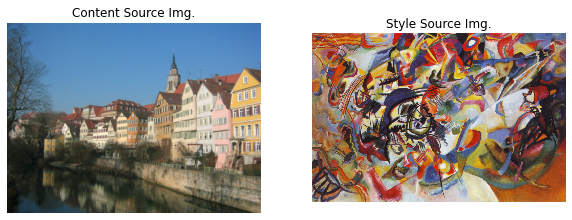

Iteration 0


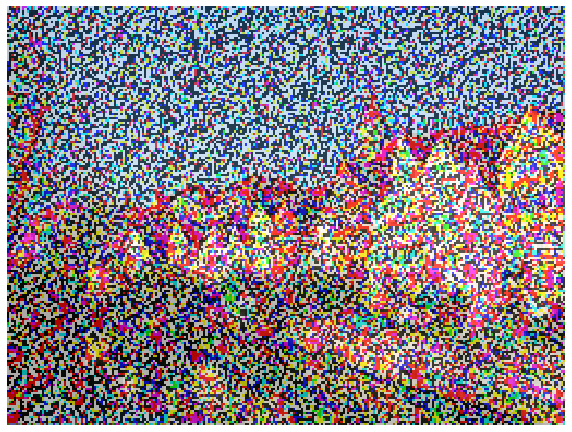

Iteration 100


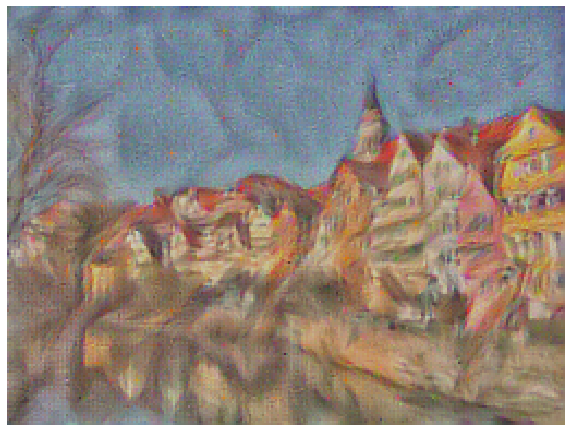

Iteration 199


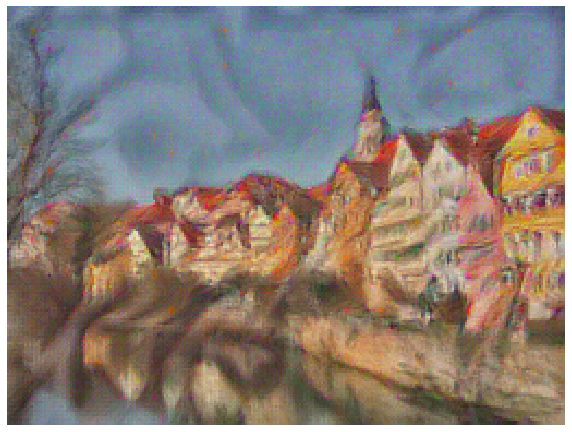

In [38]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
params1 = {
    'model'         : cnn_model,
    
    'content_path'  : 'tubingen.jpg',
    'style_path'    : 'composition_vii.jpg',
    
    'content_size'  : 192,
    'style_size'    : 512,
    
    'content_layer' : 3,
    'content_weight': 5e-2, 
    
    'style_layers'  : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    
    'tv_weight'     : 5e-2
}

style_transfer(**params1)

---
### b. Scream + Tubingen

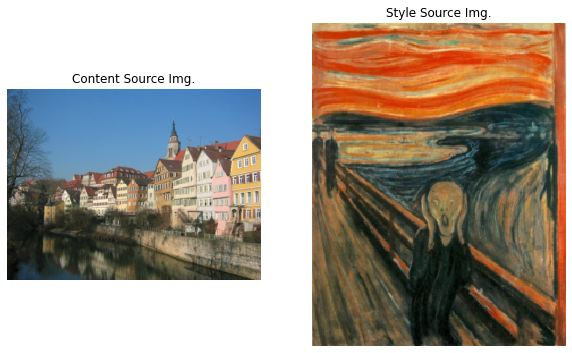

Iteration 0


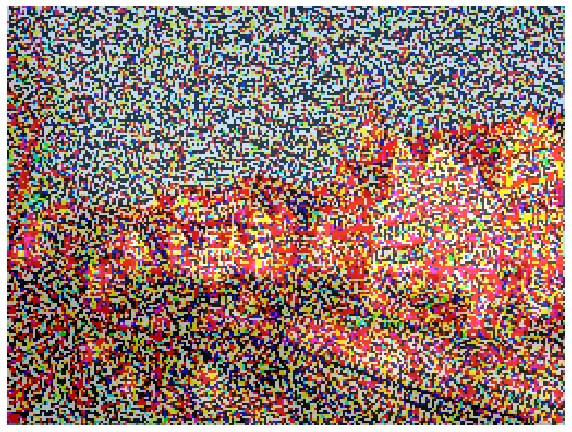

Iteration 100


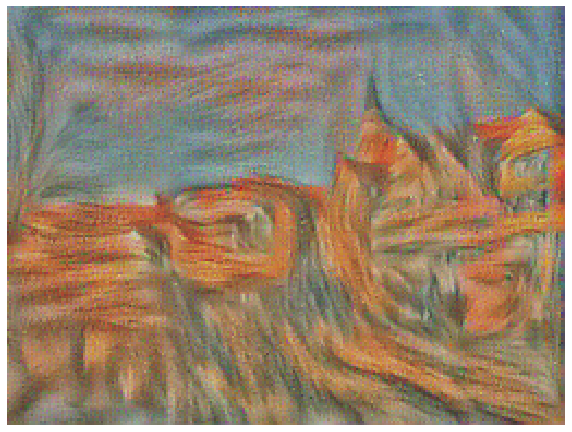

Iteration 199


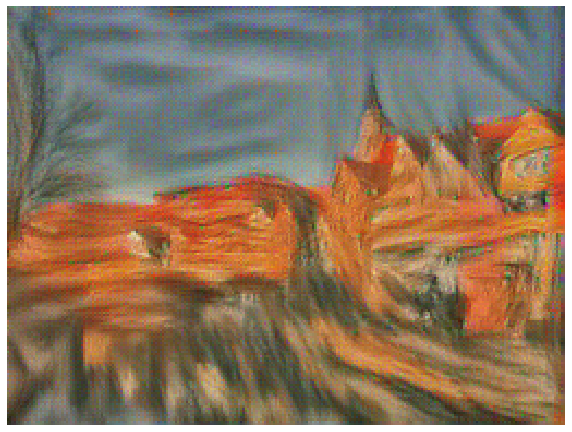

In [39]:
params2 = {
    'model'         : cnn_model,
    
    'content_path'  :'tubingen.jpg',
    'style_path'    :'the_scream.jpg',
    
    'content_size'  :192,
    'style_size'    :224,
    
    'content_layer' :3,
    'content_weight':3e-2,
    
    'style_layers'  :[1, 4, 6, 7],
    'style_weights' :[200000, 800, 12, 1],
    
    'tv_weight'     :2e-2
}

style_transfer(**params2)

---
### c. Starry Night + Tubingen

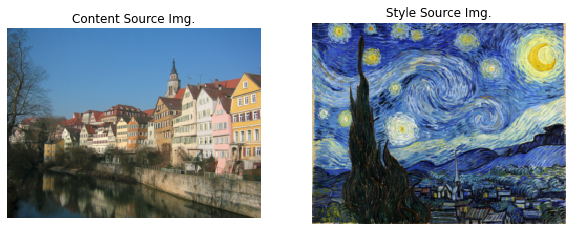

Iteration 0


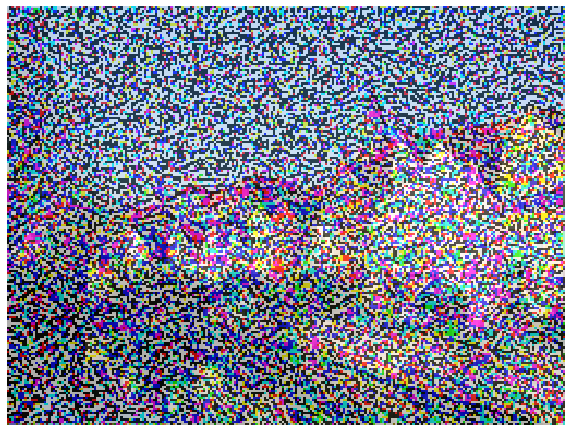

Iteration 100


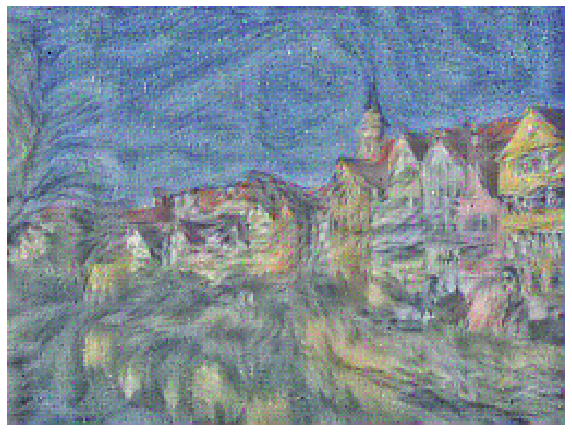

Iteration 199


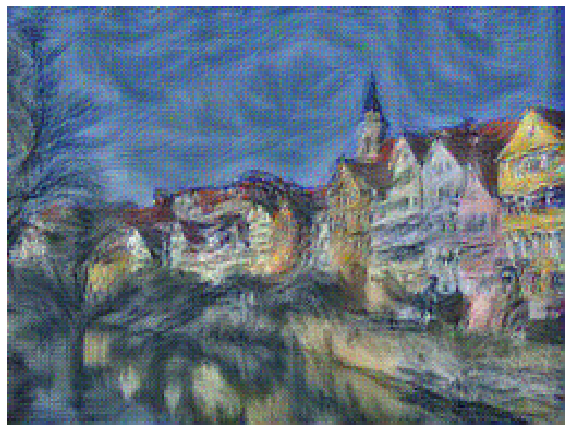

In [40]:
params3 = {
    'model'         : cnn_model,
    
    'content_path'  : 'tubingen.jpg',
    'style_path'    : 'starry_night.jpg',
    
    'content_size'  : 192,
    'style_size'    : 192,
    
    'content_layer' : 3,
    'content_weight': 6e-2,
    
    'style_layers'  : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    
    'tv_weight'     : 2e-2
}

style_transfer(**params3)

---
---
# [Part 7] Feature Inversion + Texture Synthesis

You know that the Style Transfer is actually a combination of both **Feature Inversion** of the content and **Texture Synthesis** of the style



---
## 1 - Feature Inversion

Feature Inversion as explained in [1] attempts to reconstruct an image from its extracted feature representation.

Now, if you set the style weights to all be $0$ and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. 

You're starting with total noise, but you should end up with something that looks quite a bit like your original image.


[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015


Run the following cell to try out feature inversion from Starry Night + Tubingen.

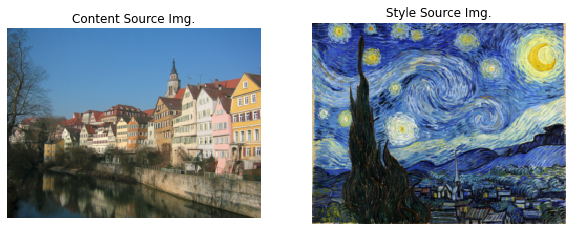

Iteration 0


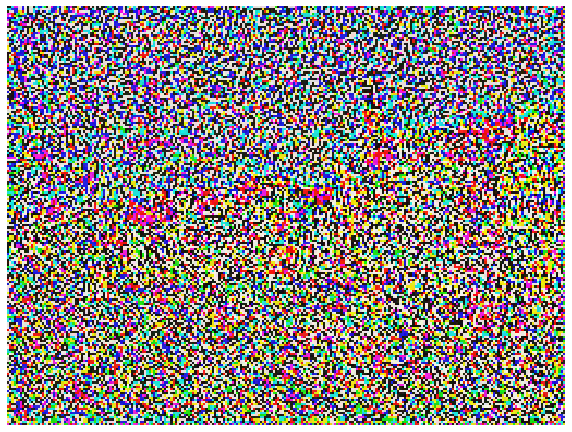

Iteration 100


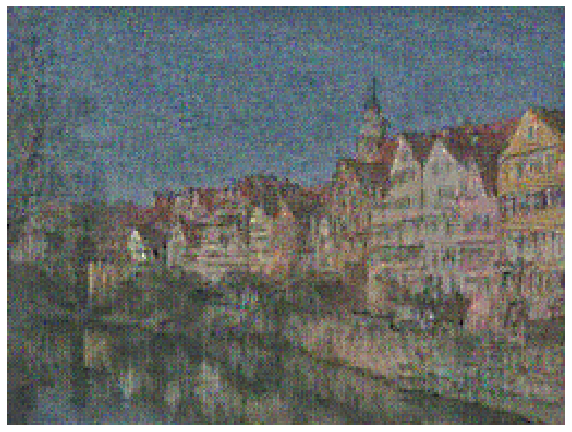

Iteration 200


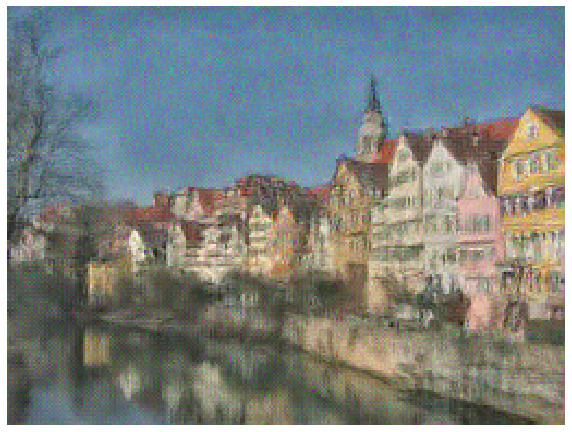

Iteration 299


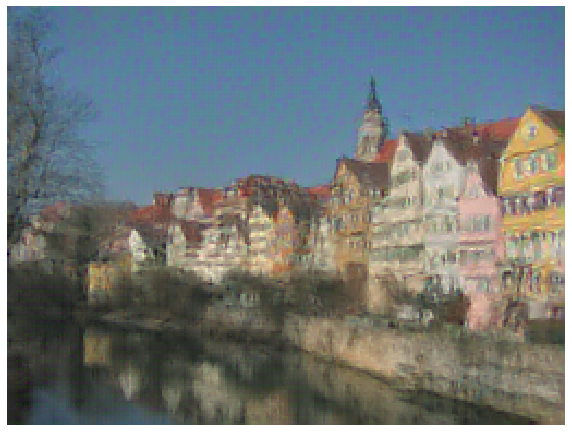

In [41]:
params_inv = {
    'model'         : cnn_model,
    
    'content_path'  : 'tubingen.jpg',
    'style_path'    : 'starry_night.jpg',
    
    'content_size'  : 192,
    'style_size'    : 192,
    
    'content_layer' : 3,
    'content_weight': 6e-2,
    
    'style_layers'  : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0],  # we discard any contributions from style to the loss
    
    'tv_weight'     : 2e-2,
    'init_random'   : True,          # we want to initialize our image to be random
    'iterations'    : 300
}

style_transfer(**params_inv)

---
## 2 - Texture Synthesis

Similarly, you could do "texture synthesis" from scratch if you set the content weight to $0$ and initialize the starting image to random noise


Run the following cell to try out texture synthesis from Starry Night + Tubingen.

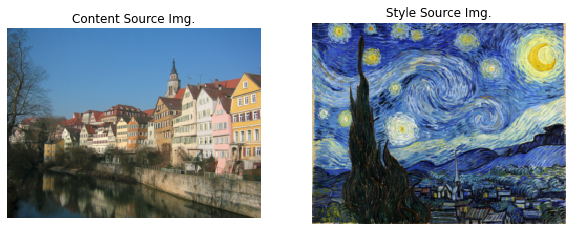

Iteration 0


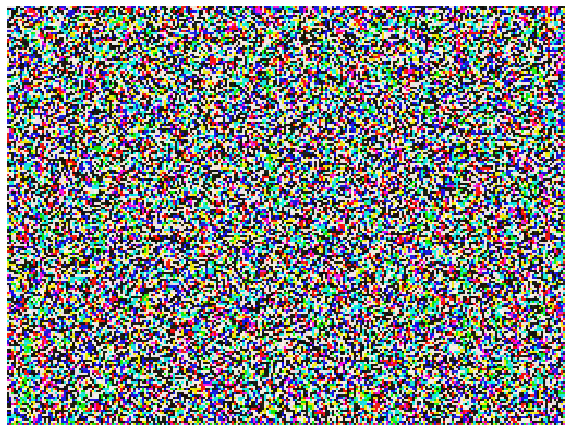

Iteration 100


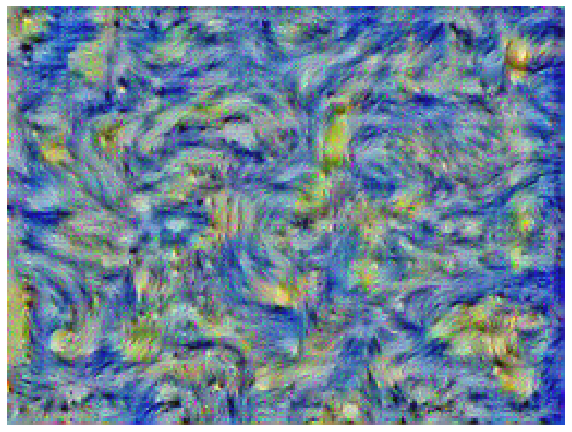

Iteration 200


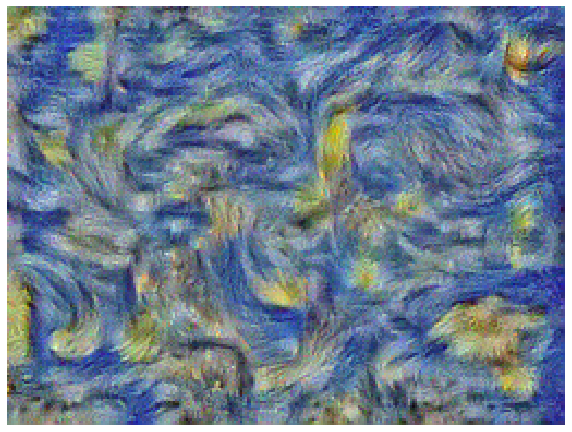

Iteration 299


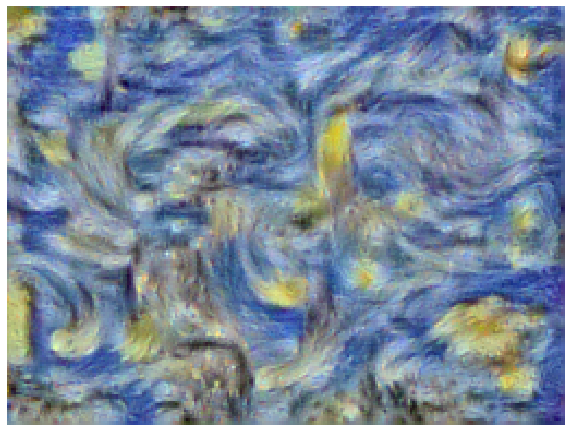

In [42]:
params_synt = {
    'model'         : cnn_model,
    
    'content_path'  : 'tubingen.jpg',
    'style_path'    : 'starry_night.jpg',
    
    'content_size'  : 192,
    'style_size'    : 192,
    
    'content_layer' : 3,
    'content_weight': 0,             # we discard any contributions from content to the loss
    
    'style_layers'  : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    
    'tv_weight'     : 2e-2,
    'init_random'   : True,          # we want to initialize our image to be random
    'iterations'    : 300
}

style_transfer(**params_synt)

---
---

# Congratulation, You've Completed Exercise 13

<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)